In [4]:
!pip install opencv-python

In [8]:
import os
import glob
import pydicom
import numpy as np
import cv2
from scipy.ndimage import zoom
from tqdm import tqdm
import cv2
import pandas as pd
import math

def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

def load_slices(patient):
    '''
    Load slices
    '''
    sorted_imgs = sorted(glob.glob('../datasets/kaggle-brain-tumor/train/'+patient+'/T1w/*.dcm'))
    slices = [pydicom.read_file(s) for s in sorted_imgs]
    
    # selective filtering
    lb = math.floor(0.20*len(slices))
    ub = math.floor(0.80*len(slices))
    slices = slices[lb:ub]
    
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

def remove_blanks(hu_images):
    '''
    remove blank images form the collection
    '''
    blanked_images = []
    for i in range(hu_images.shape[0]):
        if np.min(hu_images[i]) != np.max(hu_images[i]):
            blanked_images.append(hu_images[i])
    return np.array(blanked_images, dtype=np.int16)

def siz(img):
    desired_depth = 64
    current_depth = img.shape[0]
    depth = current_depth / desired_depth
    depth_factor = 1 / depth
    img_new = zoom(img, (depth_factor, 1, 1), mode='nearest')
    return img_new

def normalize(img):
    #mini = np.min(img)
    #maxi = np.max(img)
    mini = -465
    maxi = 5840
    img = (img - mini) / (maxi - mini)
    return img

def resize_images(img, resize_dim=256):
    resized = []
    for i in range(img.shape[0]):
        im = img[i]
        img_t = cv2.resize(im, (resize_dim, resize_dim))
        resized.append(img_t)
    return np.array(resized)

def get_label(patient, df):
    label = df._get_value(patient, 'MGMT_value')
    if label == 1:
        label = np.array(1)
    elif label == 0:
        label = np.array(0)
    return label
    


In [16]:
patients = os.listdir('../datasets/kaggle-brain-tumor/train')

labels_df = pd.read_csv('../datasets/kaggle-brain-tumor/train_labels.csv', converters={'BraTS21ID': lambda x: str(x)})
labels_df = labels_df.set_index('BraTS21ID')

for patient in tqdm(patients):
    if patient in ['00109', '00123', '00709']:
        continue
    output = []
    slices = load_slices(patient) 
    hu_images = get_pixels_hu(slices)
    images = remove_blanks(hu_images)
    im = []
    for j in range(images.shape[0]):
        im.append(cv2.resize(images[j], (256, 256)))
    images = np.array(im)
    images = siz(images)
    images = normalize(images)
    
    label = labels_df._get_value(patient, 'MGMT_value')
    if label == 1:
        label = np.array(1)
    elif label == 0:
        label = np.array(0)
    
    output.append([images, label])
    all_data_numpy = np.array(output)
    filename = patient + '.npy'
    np.save(filename, all_data_numpy)


  0%|                                                                                          | 0/585 [00:00<?, ?it/s]<ipython-input-16-1519d7374f0d>:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  all_data_numpy = np.array(output)
100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [17:54<00:00,  1.84s/it]


In [10]:
print(all_data_numpy[0][0][56])

[[0.07375099 0.07375099 0.07375099 ... 0.07375099 0.07375099 0.07375099]
 [0.07375099 0.07375099 0.07375099 ... 0.07375099 0.07375099 0.07375099]
 [0.07375099 0.07375099 0.07375099 ... 0.07375099 0.07375099 0.07375099]
 ...
 [0.07375099 0.07375099 0.07375099 ... 0.07375099 0.07375099 0.07375099]
 [0.07375099 0.07375099 0.07375099 ... 0.07375099 0.07375099 0.07375099]
 [0.07375099 0.07375099 0.07375099 ... 0.07375099 0.07375099 0.07375099]]


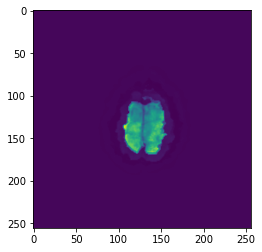

In [15]:
import matplotlib.pyplot as plt
plt.imshow(all_data_numpy[0][0][59])

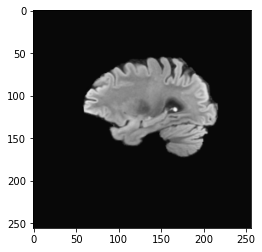

In [26]:
import matplotlib.pyplot as plt
plt.imshow(all_data_numpy[0][0][45], cmap='gray')

In [14]:
os.listdir('./')

['00000.npy', 'converter.ipynb', '.ipynb_checkpoints']

In [15]:
import numpy as np
sata = np.load('./00000.npy', allow_pickle=True)

In [17]:
sata[0][0].shape

(64, 256, 256)

## Evaluating dataset mean

In [9]:
patients = os.listdir('/run/media/aryaman/T7/datasets/kaggle-brain-tumor/train')

labels_df = pd.read_csv('/run/media/aryaman/T7/datasets/kaggle-brain-tumor/train_labels.csv', converters={'BraTS21ID': lambda x: str(x)})
labels_df = labels_df.set_index('BraTS21ID')

output = []
min_val = 1000
max_val = -1000
for patient in tqdm(patients):
    if patient in ['00109', '00123', '00709']:
        continue
    
    slices = load_slices(patient) 
    hu_images = get_pixels_hu(slices)
    images = remove_blanks(hu_images)
    im = []
    for j in range(images.shape[0]):
        im.append(cv2.resize(images[j], (256, 256)))
    images = np.array(im)
    images = siz(images)
    #output.append(images)
    if np.min(images) < min_val:
        min_val = np.min(images)
    if np.max(images) > max_val:
        max_val = np.max(images)
    
    

100%|██████████| 585/585 [30:57<00:00,  3.18s/it] 


In [10]:
print(min_val, max_val)

-465 5840
